# Spiral Autoencoder

This notebooks takes on training four different autoencoders - one for each spiral class.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
def remove_end_line(x, y, tol=1e-6):
    x = np.asarray(x)
    y = np.asarray(y)
    
    if len(x) < 3:
        return x, y
    
    last_point = np.array([x[-1], y[-1]])
    second_last_point = np.array([x[-2], y[-2]])
    line_vec = last_point - second_last_point
    
    for i in range(len(x) - 2, 0, -1):
        point = np.array([x[i], y[i]])
        vec = point - second_last_point
        cross = line_vec[0] * vec[1] - line_vec[1] * vec[0]
        if abs(cross) > tol:
            return x[:i+1], y[:i+1]
    
    return x, y

def plot_segmented_spiral(
    gen_theta,
    gen_r,
    num_segments=10,
    num_points=500,
    colors=None,
    figsize=(12, 6),
    plot_title=None,
    axes=None
):
    """
    Generates and plots a spiral with segments of different colors.

    Parameters:
    - num_segments (int): The number of colored segments to divide the plot into.
    - num_points (int): The total number of points to generate for the spiral. Default is 500.
    - theta_end (int): The number of full rotations (2*pi) for the spiral. Default is 10.
    - noise_range (tuple): A tuple (min, max) for adding random noise to the radius.
                           Default is (-10, 10).
    - colors (list or None): A list of colors to use for the segments. If None,
                             Matplotlib's default color cycle will be used.
    - figsize (tuple): A tuple (width, height) for the figure size. Default is (12, 6).
    - plot_title (str or None): Title for the entire plot. If None, 'Spiral Generation with {num_segments} Segments' is set.
    - axes (tuple or None): A tuple of Matplotlib axes to plot on. If None, new axes will be created.
    """
    
    points_per_segment = num_points // num_segments
    segments_theta = [
        gen_theta[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    segments_r = [
        gen_r[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    
    # Use default colors if none are provided
    if colors is None:
        cmap = plt.colormaps['tab20']
        colors = [cmap(i) for i in range(num_segments)]
    colors = [colors[i % len(colors)] for i in range(num_segments)]

    # 3. Create the plots
    if axes is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'wspace': 0.2})
        ax2 = fig.add_subplot(1, 2, 2, projection='polar')
    else:
        ax1, ax2 = axes

    # Cartesian subplot (Radius vs Theta)
    for i in range(num_segments):
        ax1.plot(np.unwrap(segments_theta[i]), segments_r[i], color=colors[i])
    
    ax1.set_title("Radius vs Theta")
    ax1.grid(True)
    
    
    theta_end = int(gen_theta[-1] / np.pi)
    tick_positions = np.linspace(0, theta_end * np.pi, theta_end + 1)
    tick_labels = [f'{i}π' for i in range(theta_end + 1)]
    
    ax1.set_xticks(tick_positions, tick_labels)
    ax1.set_xlabel("Theta (radians)")
    ax1.set_ylabel("Radius")

    # Polar subplot (Spiral)
    for i in range(num_segments):
        ax2.plot(segments_theta[i], segments_r[i], color=colors[i])
    
    ax2.set_title("Generated spiral")
    ax2.grid(False)
    ax2.axis('off')
    
    if plot_title:
        plt.suptitle(plot_title)
    else:
        plt.suptitle(f"Spiral Generation with {num_segments} Segments")
    
    if axes is None:
        plt.show()
    else: 
        return ax1, ax2

### Data preparation

In [113]:
class SpiralDataset(Dataset):
    def __init__(self, folder, preload=True):
        self.files = list(Path(folder).glob("*.csv"))
        self.preload = preload
        if preload:
            self.data = [pd.read_csv(f)[['r', 'theta']].values.astype('float32') for f in self.files]
            # self.data = [pd.read_csv(f)[['r', 'theta']].iloc[::2].values.astype('float32') for f in self.files]
        else:
            self.data = None

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if self.preload:
            arr = self.data[idx]
        else:
            df = pd.read_csv(self.files[idx])
            arr = df[['r', 'theta']].values.astype('float32')
        return torch.tensor(arr)

FIXED_LEN = 600

def collate_pad_fixed(batch, fixed_len=FIXED_LEN):
    """
    Pads or truncates each spiral to a fixed length.
    Each batch element is a tensor of shape (seq_len, 2).
    Returns (padded_batch, lengths)
    """
    new_batch = []
    lengths = []
    
    for x in batch:
        seq_len = x.size(0)
        lengths.append(min(seq_len, fixed_len))
        
        if seq_len < fixed_len:
            # pad with zeros
            pad = torch.zeros(fixed_len - seq_len, 2, dtype=x.dtype)
            new_x = torch.cat([x, pad], dim=0)
        else:
            # truncate
            new_x = x[:fixed_len]
        
        new_batch.append(new_x)
    
    padded_batch = torch.stack(new_batch, dim=0)  # (B, fixed_len, 2)
    lengths = torch.tensor(lengths, dtype=torch.int64)
    
    return padded_batch, lengths

### Autoencoder class

In [114]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, latent_dim=64):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x):
        # x: (B, T, 2)
        B, T, D = x.size()
        x_flat = x.view(B*T, D)
        latent = self.encoder(x_flat)
        out_flat = self.decoder(latent)
        out = out_flat.view(B, T, D)
        return out

In [115]:
class SpiralAutoencoder(nn.Module):
    def __init__(self, input_len, latent_dim=16, hidden_dim=128):
        super().__init__()
        # input_len = number of points * 2
        self.encoder = nn.Sequential(
            nn.Linear(input_len, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_len)
        )
    
    def forward(self, x):
        # x: (B, T, 2)
        B, T, D = x.size()
        x_flat = x.view(B, T*D)        # flatten spiral
        latent = self.encoder(x_flat)  # single vector per spiral
        out_flat = self.decoder(latent)
        out = out_flat.view(B, T, D)
        return out, latent

In [116]:
class LSTMAutoencoder(nn.Module):
    def __init__(self,
                 input_dim=2,
                 hidden_dim=64,
                 latent_dim=32,
                 num_layers=2,
                 dropout=0.1,
                 bidirectional=False,
                 device="cpu"):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.device = device

        # Encoder
        self.encoder_lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Bottleneck
        direction_factor = 2 if bidirectional else 1
        self.fc_mu = nn.Linear(hidden_dim * direction_factor, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, hidden_dim * direction_factor)
        
        # Decoder
        self.decoder_lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.output_layer = nn.Linear(hidden_dim * direction_factor, input_dim)

    def encode(self, x, lengths):
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h, _) = self.encoder_lstm(packed)
        
        if self.bidirectional:
            h = torch.cat((h[-2], h[-1]), dim=1)
        else:
            h = h[-1]
        
        latent = self.fc_mu(h)
        return latent

    def decode(self, latent, seq_len):
        # Expand latent vector to all time steps
        hidden = self.fc_decode(latent).unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)
        
        # Decoder input: start with zeros
        decoder_input = torch.zeros(latent.size(0), seq_len, self.input_dim, device=self.device)
        output, _ = self.decoder_lstm(decoder_input, (hidden, cell))
        output = self.output_layer(output)
        return output

    def forward(self, x, lengths):
        latent = self.encode(x, lengths)
        max_len = x.size(1)
        reconstructed = self.decode(latent, max_len)
        return reconstructed, latent

### Training

In [117]:
def masked_mse_loss_flat(reconstructed, target, lengths):
    """
    Computes MSE loss ignoring padded elements for flattened spirals.

    reconstructed: (B, T*D)
    target: (B, T*D)
    lengths: (B,)  # number of valid points per spiral
    """
    B, TD = target.size()
    D = 2  # r and theta
    T = TD // D

    # create mask for valid time steps
    mask = torch.arange(T, device=target.device).unsqueeze(0) < lengths.unsqueeze(1)  # (B, T)
    mask = mask.repeat_interleave(D, dim=1)  # (B, T*D)

    diff = (reconstructed - target) ** 2
    diff = diff * mask
    loss = diff.sum() / mask.sum()
    return loss

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0

    for batch_data, lengths in dataloader:
        batch_data = batch_data.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        reconstructed, _ = model(batch_data, lengths)
        loss = masked_mse_loss_flat(reconstructed, batch_data, lengths)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(batch_data)  # weight by batch size

    return total_loss / len(dataloader.dataset)

def train_epoch_simple(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_data, lengths in dataloader:
        batch_data = batch_data.to(device)
        lengths = lengths.to(device)
        
        B, T, D = batch_data.size()
        
        optimizer.zero_grad()
        reconstructed, _ = model(batch_data)
        reconstructed_flat = reconstructed.view(B, T*D)
        batch_flat = batch_data.view(B, T*D)
        loss = masked_mse_loss_flat(reconstructed_flat, batch_flat, lengths)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(batch_data)
    return total_loss / len(dataloader.dataset)

In [118]:
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0

    for batch_data, lengths in dataloader:
        batch_data = batch_data.to(device)
        lengths = lengths.to(device)

        reconstructed, _ = model(batch_data, lengths)
        loss = masked_mse_loss_flat(reconstructed, batch_data, lengths)

        total_loss += loss.item() * len(batch_data)

    return total_loss / len(dataloader.dataset)

@torch.no_grad()
def evaluate_simple(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_data, lengths in dataloader:
            batch_data = batch_data.to(device)
            lengths = lengths.to(device)
            reconstructed, _ = model(batch_data)
            B, T, D = batch_data.size()
            loss = masked_mse_loss_flat(
                reconstructed.view(B, T*D),
                batch_data.view(B, T*D),
                lengths
            )
            total_loss += loss.item() * len(batch_data)
    return total_loss / len(dataloader.dataset)


In [124]:
# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model
# model = LSTMAutoencoder(
#     input_dim=2,
#     hidden_dim=128,
#     latent_dim=64,
#     num_layers=2,
#     dropout=0.2,
#     bidirectional=False,
#     device=device
# ).to(device)

model = SpiralAutoencoder(input_len=FIXED_LEN*2, hidden_dim=256, latent_dim=128).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 300

# Dataset
data_folder = "./syn_data/tight/"
full_dataset = SpiralDataset(data_folder)

# Split into train/validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_pad_fixed)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_pad_fixed)

# Training loop
train_losses, val_losses = [], []

print("Starting training...")
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch_simple(model, train_loader, optimizer, device)
    val_loss = evaluate_simple(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

Starting training...
Epoch 01 | Train Loss: 148.193486 | Val Loss: 44.357964
Epoch 02 | Train Loss: 20.146437 | Val Loss: 12.800854
Epoch 03 | Train Loss: 10.337461 | Val Loss: 10.977858
Epoch 04 | Train Loss: 9.333080 | Val Loss: 10.215815
Epoch 05 | Train Loss: 8.564719 | Val Loss: 9.172282
Epoch 06 | Train Loss: 7.313690 | Val Loss: 7.626054
Epoch 07 | Train Loss: 5.953015 | Val Loss: 6.402197
Epoch 08 | Train Loss: 5.188615 | Val Loss: 5.829106
Epoch 09 | Train Loss: 4.835648 | Val Loss: 5.544996
Epoch 10 | Train Loss: 4.554027 | Val Loss: 5.314746
Epoch 11 | Train Loss: 4.173974 | Val Loss: 4.630372
Epoch 12 | Train Loss: 3.632179 | Val Loss: 3.951787
Epoch 13 | Train Loss: 3.012977 | Val Loss: 3.290656
Epoch 14 | Train Loss: 2.497595 | Val Loss: 2.735580
Epoch 15 | Train Loss: 2.072050 | Val Loss: 2.210818
Epoch 16 | Train Loss: 1.723357 | Val Loss: 1.851895
Epoch 17 | Train Loss: 1.475000 | Val Loss: 1.640021
Epoch 18 | Train Loss: 1.378451 | Val Loss: 1.543892
Epoch 19 | Train 

### Results

In [9]:
# def plot_reconstruction(model, dataloader, device, num_samples=5, num_segments=15):
#     model.eval()
#     with torch.no_grad():
#         # Get one batch
#         for batch_data, lengths in dataloader:
#             batch_data = batch_data.to(device)
#             lengths = lengths.to(device)
#             reconstructed, _ = model(batch_data, lengths)
#             break  # only take first batch

#     batch_data = batch_data.cpu()
#     reconstructed = reconstructed.cpu()
#     lengths = lengths.cpu()

#     num_samples = min(num_samples, batch_data.size(0))

#     fig, axs = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
#     if num_samples == 1:
#         axs = axs.reshape(1, 2)

#     for i in range(num_samples):
#         orig_len = lengths[i]
#         orig_theta = batch_data[i, :orig_len, 1]
#         orig_r = batch_data[i, :orig_len, 0]

#         recon_theta = reconstructed[i, :orig_len, 1]
#         recon_r = reconstructed[i, :orig_len, 0]

#         ax1, ax2 = axs[i]

#         # Plot original spiral in grey
#         plot_segmented_spiral(
#             gen_theta=orig_theta,
#             gen_r=orig_r,
#             num_segments=1,
#             axes=(ax1, ax2),
#             colors=['#999999'],
#             plot_title=f"Sample {i+1} - Original"
#         )

#         # Plot reconstructed spiral in color
#         plot_segmented_spiral(
#             gen_theta=recon_theta,
#             gen_r=recon_r,
#             num_segments=num_segments,
#             axes=(ax1, ax2),
#             plot_title=f"Sample {i+1} - Reconstruction"
#         )

#     plt.tight_layout()
#     plt.show()

# plot_reconstruction(model, val_loader, device, num_samples=3, num_segments=10)

In [120]:
def spiral_reconstruction_simple(r, theta, model, device='cpu'):
    model.eval()
    with torch.no_grad():
        # Prepare input as tensor of shape (1, seq_len, 2)
        x = torch.tensor(list(zip(r, theta)), dtype=torch.float32).unsqueeze(0).to(device)
        
        # If your model expects fixed-length input, pad to model's expected length
        expected_len = model.encoder[0].in_features // 2  # number of points
        seq_len = x.size(1)
        if seq_len < expected_len:
            pad = torch.zeros(1, expected_len - seq_len, 2, device=device)
            x = torch.cat([x, pad], dim=1)
        
        reconstructed, _ = model(x)  # unpack tuple
        reconstructed = reconstructed[:, :seq_len, :]  # trim padded part
        recon = reconstructed.squeeze(0).cpu()  # shape: (seq_len, 2)

    recon_r = recon[:, 0].numpy()
    recon_theta = recon[:, 1].numpy()
    return recon_r, recon_theta

In [125]:
def plot_spiral_reconstruction(model, dataloader, device, num_samples=5):
    model.eval()
    with torch.no_grad():
        for batch_data, lengths in dataloader:
            batch_data = batch_data.to(device)
            lengths = lengths.to(device)
            reconstructed, _ = model(batch_data, lengths)
            break  # only take first batch

    batch_data = batch_data.cpu()
    reconstructed = reconstructed.cpu()
    lengths = lengths.cpu()

    num_samples = min(num_samples, batch_data.size(0))
    fig, axs = plt.subplots(1, num_samples, figsize=(4*num_samples, 4), subplot_kw={'projection':'polar'})

    if num_samples == 1:
        axs = [axs]

    for i in range(num_samples):
        seq_len = lengths[i]
        orig_r = batch_data[i, :seq_len, 0]
        orig_theta = batch_data[i, :seq_len, 1]

        recon_r = reconstructed[i, :seq_len, 0]
        recon_theta = reconstructed[i, :seq_len, 1]

        ax = axs[i]
        ax.plot(orig_theta, orig_r, color='grey', lw=2, label='Original')
        ax.plot(recon_theta, recon_r, color='blue', lw=2, label='Reconstruction')
        ax.axis('off')
        ax.set_title(f"Sample {i+1}")

    plt.tight_layout()
    plt.show()
    
def plot_spiral_reconstruction_simple(model, dataloader, device, num_samples=5, plot=True):
    model.eval()
    with torch.no_grad():
        for batch_data, lengths in dataloader:  # lengths still come from collate
            batch_data = batch_data.to(device)
            reconstructed, _ = model(batch_data)  # unpack tuple
            break  # only take first batch

    batch_data = batch_data.cpu()
    reconstructed = reconstructed.cpu()
    lengths = lengths.cpu()

    num_samples = min(num_samples, batch_data.size(0))
    if plot:
        _, axs = plt.subplots(1, num_samples, figsize=(4*num_samples, 4), subplot_kw={'projection':'polar'})

        if num_samples == 1:
            axs = [axs]

    recon_rs = []
    recon_thetas = []
    for i in range(num_samples):
        seq_len = lengths[i]  # trim to original length
        orig_r = batch_data[i, :seq_len, 0]
        orig_theta = batch_data[i, :seq_len, 1]

        recon_r = reconstructed[i, :seq_len, 0]
        recon_theta = reconstructed[i, :seq_len, 1]
        recon_rs.append(recon_r)
        recon_thetas.append(recon_theta)

        if plot:
            ax = axs[i]
            ax.plot(orig_theta, orig_r, color='grey', lw=2)
            ax.plot(recon_theta, recon_r, color='blue', lw=2)
            ax.axis('off')
            ax.set_title(f"Sample {i+1}")

    # optional legend
    if plot:
        axs[0].plot([], [], color='grey', lw=2, label='Original')
        axs[0].plot([], [], color='blue', lw=2, label='Reconstruction')
        axs[0].legend(loc='upper right')

        plt.tight_layout()
        plt.show()
    
    return recon_rs, recon_thetas

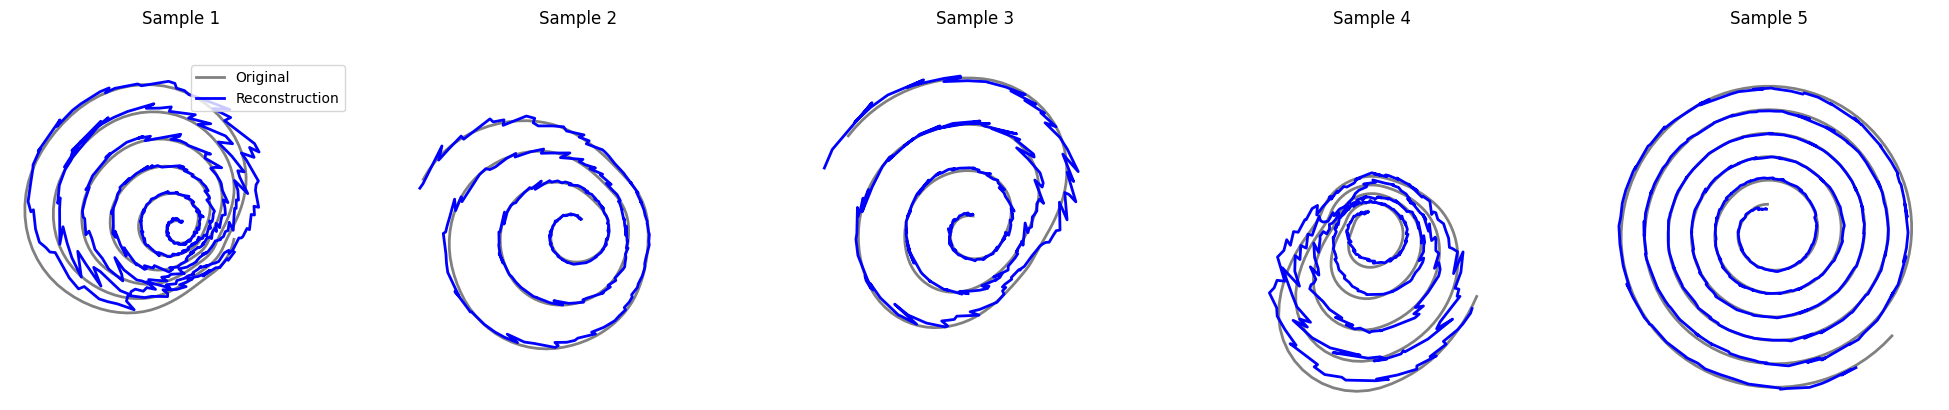

In [126]:
rs, thetas = plot_spiral_reconstruction_simple(model, val_loader, device, num_samples=5)

In [99]:
def plot_single_spiral_reconstruction(r, theta, model, device='cpu'):
    """
    r, theta: 1D numpy arrays or tensors representing a single spiral
    model: trained autoencoder (simple feedforward)
    device: 'cpu' or 'cuda'
    """
    model.eval()
    with torch.no_grad():
        # Prepare input as tensor of shape (1, seq_len, 2)
        x = torch.tensor(list(zip(r, theta)), dtype=torch.float32).unsqueeze(0).to(device)
        
        # If your model expects fixed-length input, pad to model's expected length
        expected_len = model.encoder[0].in_features // 2  # number of points
        seq_len = x.size(1)
        if seq_len < expected_len:
            pad = torch.zeros(1, expected_len - seq_len, 2, device=device)
            x = torch.cat([x, pad], dim=1)
        
        reconstructed, _ = model(x)  # unpack tuple
        reconstructed = reconstructed[:, :seq_len, :]  # trim padded part
        recon = reconstructed.squeeze(0).cpu()  # shape: (seq_len, 2)

    recon_r = recon[:, 0].numpy()
    recon_theta = recon[:, 1].numpy()

    # Plot
    plt.figure(figsize=(6,6))
    ax = plt.subplot(projection='polar')
    ax.plot(theta, r, color='grey', lw=2, label='Original')
    ax.plot(recon_theta, recon_r, color='blue', lw=2, label='Reconstruction')
    ax.axis('off')
    ax.legend()
    plt.show()

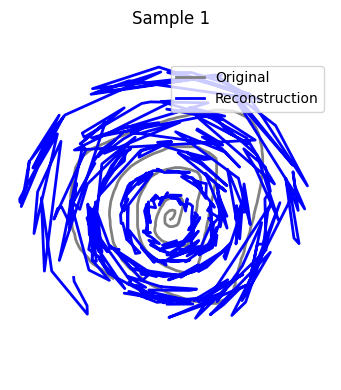

In [127]:
df = pd.read_csv("drawings/long/l_all_dft_reconstructed_500.csv")
grouped = df.groupby("original_file")
sp_name, sp_df = list(grouped)[4]

sp_x = sp_df['x'] - sp_df['x'].iloc[0]
sp_y = sp_df['y'] - sp_df['y'].iloc[0]
sp_x, sp_y = remove_end_line(sp_x, sp_y, tol=1e-6)
sp_y = sp_y  # Invert y-axis if needed
sp_r = np.sqrt(sp_x**2 + sp_y**2) / 10.0  # scale down
sp_theta = np.arctan2(sp_y, sp_x)
sp_theta = np.unwrap(sp_theta)

temp_df = pd.DataFrame({'r': sp_r, 'theta': sp_theta})
temp_df.to_csv("temp_results/temp_spiral.csv", index=False)
test_dataset = SpiralDataset("temp_results", preload=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_pad_fixed)
recon_rs, recon_thetas = plot_spiral_reconstruction_simple(model, test_loader, device, num_samples=1)

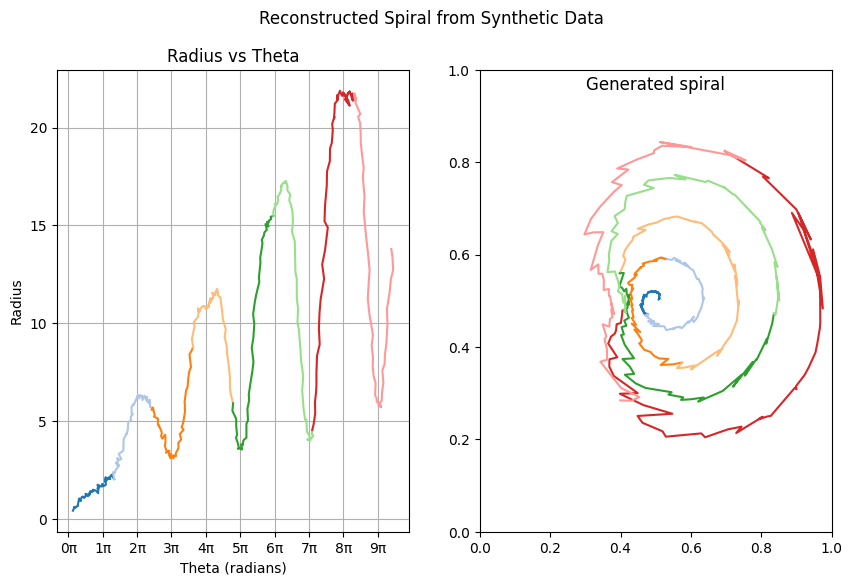

In [128]:
df_syn = pd.read_csv("syn_data/tight/tight_spiral_42.csv")
r_syn, theta_syn = df_syn['r'].values, df_syn['theta'].values

theta_syn = np.unwrap(theta_syn)

temp_df = pd.DataFrame({'r': r_syn, 'theta': theta_syn})
temp_df.to_csv("temp_results/temp_spiral.csv", index=False)
test_dataset = SpiralDataset("temp_results", preload=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_pad_fixed)

recon_rs, recon_thetas = plot_spiral_reconstruction_simple(model, test_loader, device, num_samples=1, plot=False)
plot_segmented_spiral(
    gen_theta=recon_thetas[0],
    gen_r=recon_rs[0],
    num_segments=10,
    figsize=(10,6),
    plot_title="Reconstructed Spiral from Synthetic Data"
)